In [79]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [81]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:02<00:00, 37.51it/s]


In [82]:
# missing value check

train_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')


In [83]:
new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [84]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

/tmp/ipykernel_373063/2767777812.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


In [85]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_train_df[col]).any()) | (np.isinf(new_train_df[col]).any()):
        print(col)
        break

In [86]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

/tmp/ipykernel_373063/3218535113.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_test_stab = new_test_stab.fillna(method='ffill')


In [87]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [88]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing, errors='ignore')

In [89]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [90]:
# Standardization으로 정규화
from sklearn.preprocessing import StandardScaler

def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train_split, y_train_split)

# 검증 데이터에서 예측
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = y_pred

# 결과 확인
std_test_df.head()

Mean Squared Error on Validation Set: 0.000627738281654192


,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_network-data_fees_fees_reward_percent,...,hourly_network-data_addresses-count_addresses_count_sender,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,hourly_network-data_utxo-count_utxo_count
8760,2024-01-01 00:00:00,NaN,test,0.862267,-1.106685,0.628514,1.123435,-0.368791,0.047456,3.380109,...,-0.333541,-1.275562,-0.846352,1.945012,2.242378,2.305764,-0.048054,-0.099003,-0.052688,2.198334
8761,2024-01-01 01:00:00,NaN,test,1.129189,-1.186934,0.709193,1.203588,-0.359145,0.106802,2.357192,...,2.749899,-0.856214,1.958204,4.171627,4.675388,2.305348,-0.048054,-0.099003,-0.052688,2.199442
8762,2024-01-01 02:00:00,NaN,test,1.435859,0.022434,-0.173300,-0.004335,-0.671636,-0.671125,2.202971,...,0.872912,-0.958328,0.355601,2.247406,2.580664,2.302622,-0.048054,-0.099003,-0.052688,2.200676
8763,2024-01-01 03:00:00,NaN,test,1.686091,1.514450,-0.737805,-1.494569,0.141968,-0.415430,2.127932,...,0.519154,-1.844483,-0.045050,1.763478,2.048809,2.298509,-0.048054,-0.099003,-0.052688,2.201494
8764,2024-01-01 04:00:00,NaN,test,1.702782,-2.809388,4.499324,2.824104,-0.606351,0.773042,2.205002,...,1.394110,-1.329516,0.756251,2.656814,3.007544,2.298788,-0.048054,-0.099003,-0.052688,2.202644


In [203]:
df = pd.concat([std_train_df, std_test_df], ignore_index=True)
df.head()

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_network-data_fees_fees_reward_percent,...,hourly_network-data_addresses-count_addresses_count_sender,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,hourly_network-data_utxo-count_utxo_count
0,2023-01-01 00:00:00,2.0,train,0.242277,-0.660030,0.248331,0.677313,-0.790786,-0.739005,-0.725213,...,0.364113,0.946969,2.358855,-0.472265,-0.467622,-2.083215,-0.048054,-0.099003,-0.052688,-1.216481
1,2023-01-01 01:00:00,1.0,train,0.242277,-2.214769,2.351257,2.230195,-0.812900,-0.555248,-0.688410,...,-1.394462,-0.773384,-0.846352,-0.540988,-0.496686,-2.079750,-0.048054,-0.099003,-0.052688,-1.216149
2,2023-01-01 02:00:00,1.0,train,0.242277,1.204924,-0.646820,-1.185413,-0.783052,-0.844533,-0.741502,...,-1.014429,-0.889786,0.756251,-0.528197,-0.491262,-2.081277,-0.048054,-0.099003,-0.052688,-1.216188
3,2023-01-01 03:00:00,1.0,train,0.242277,-0.654333,0.244119,0.671624,-0.841254,-0.809874,-0.731158,...,-1.459339,-0.447158,-0.445701,-0.549200,-0.500178,-2.083744,-0.048054,-0.099003,-0.052688,-1.215593
4,2023-01-01 04:00:00,2.0,train,0.242277,0.388268,-0.346476,-0.369732,-0.660023,-0.701877,-0.719856,...,-1.043804,0.343477,0.355601,-0.521007,-0.488245,-2.085260,-0.048054,-0.099003,-0.052688,-1.214962


In [204]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    #"hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    #"hourly_network-data_difficulty_difficulty" : "difficulty",
    #"hourly_market-data_open-interest_all_exchange_all_symbol_open_interest" : "open_interest",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    #"hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    #"hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio" : "buy_ratio_bi",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio" : "sell_ratio_bi",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    #"hourly_network-data_addresses-count_addresses_count_active": "active_count",
    #"hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    #"hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close" : "close",
}
df=df[cols_dict.keys()].rename(cols_dict, axis=1)

df.shape
df.head()

,ID,target,_type,long_liquidations,short_liquidations,buy_ratio,buy_ratio_bi,buy_volume,sell_ratio,sell_ratio_bi,sell_volume,close
0,2023-01-01 00:00:00,2.0,train,-0.266362,-0.258088,-0.500339,-0.568507,-0.712152,0.500339,0.568507,-0.704407,-2.083215
1,2023-01-01 01:00:00,1.0,train,-0.266509,-0.249062,2.713390,2.302074,-0.733461,-2.713390,-2.302074,-0.791420,-2.079750
2,2023-01-01 02:00:00,1.0,train,-0.266509,-0.258088,0.187680,-0.141729,-0.783198,-0.187680,0.141729,-0.793332,-2.081277
3,2023-01-01 03:00:00,1.0,train,-0.259268,-0.258088,-0.684034,-1.109846,-0.768791,0.684034,1.109846,-0.763767,-2.083744
4,2023-01-01 04:00:00,2.0,train,-0.262101,-0.258088,-0.141937,0.108704,-0.761585,0.141937,-0.108704,-0.766216,-2.085260


In [205]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    #liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
    close_diff = df['close'].diff().fillna(method='bfill'),
    volume = df["buy_volume"] + df["sell_volume"],
    #open_diff = df["open_interest"].diff().fillna(method='bfill'),
    SMA5 = df['close'].rolling(window=5).mean().fillna(method='bfill'),  
    SMA10 = df['close'].rolling(window=10).mean().fillna(method='bfill'),
    EMA5 = df['close'].ewm(span=5, adjust=False).mean().fillna(method='bfill'),  
    EMA3 = df['close'].ewm(span=10, adjust=False).mean().fillna(method='bfill'),
    #SMA20 = df['close'].rolling(window=20).mean().fillna(method='bfill'),
    #EMA24 = df['close'].ewm(span=20, adjust=False).mean().fillna(method='bfill'),
    close_trend5 = df['close'].pct_change(periods=5).fillna(method='bfill'),
    close_trend3 = df['close'].pct_change(periods=10).fillna(method='bfill'),
    #close_trend24 = df['close'].pct_change(periods=20).fillna(method='bfill'),
)
# category, continuous 열을 따로 할당해둠
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "liquidation_diff",
    #"liquidation_usd_diff",
    "volume_diff",
    "buy_sell_volume_ratio",
    "close_diff",
    "volume",
    #"open_diff",
    "SMA10",
    "EMA3",
    "SMA5",
    "EMA5",
    "close_trend3",
    "close_trend5"
]

/tmp/ipykernel_373063/3138012987.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_diff = df['close'].diff().fillna(method='bfill'),
/tmp/ipykernel_373063/3138012987.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SMA5 = df['close'].rolling(window=5).mean().fillna(method='bfill'),
/tmp/ipykernel_373063/3138012987.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SMA10 = df['close'].rolling(window=10).mean().fillna(method='bfill'),
/tmp/ipykernel_373063/3138012987.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EMA5 = df['close'].ewm(span=5, adjust=False).mean().fillna(method='bfill'),
/tmp/ipykernel_373063/313801298

In [206]:
df.head()

,ID,target,_type,long_liquidations,short_liquidations,buy_ratio,buy_ratio_bi,buy_volume,sell_ratio,sell_ratio_bi,...,volume_diff,buy_sell_volume_ratio,close_diff,volume,SMA5,SMA10,EMA5,EMA3,close_trend5,close_trend3
0,2023-01-01 00:00:00,2.0,train,-0.266362,-0.258088,-0.500339,-0.568507,-0.712152,0.500339,0.568507,...,-0.007745,-2.409234,0.003464,-1.416560,-2.082649,-2.083285,-2.083215,-2.083215,0.000599,-0.000837
1,2023-01-01 01:00:00,1.0,train,-0.266509,-0.249062,2.713390,2.302074,-0.733461,-2.713390,-2.302074,...,0.057959,-3.516455,0.003464,-1.524881,-2.082649,-2.083285,-2.082060,-2.082585,0.000599,-0.000837
2,2023-01-01 02:00:00,1.0,train,-0.266509,-0.258088,0.187680,-0.141729,-0.783198,-0.187680,0.141729,...,0.010135,-3.789651,-0.001527,-1.576530,-2.082649,-2.083285,-2.081799,-2.082347,0.000599,-0.000837
3,2023-01-01 03:00:00,1.0,train,-0.259268,-0.258088,-0.684034,-1.109846,-0.768791,0.684034,1.109846,...,-0.005024,-3.254379,-0.002467,-1.532558,-2.082649,-2.083285,-2.082447,-2.082601,0.000599,-0.000837
4,2023-01-01 04:00:00,2.0,train,-0.262101,-0.258088,-0.141937,0.108704,-0.761585,0.141937,-0.108704,...,0.004631,-3.257641,-0.001516,-1.527801,-2.082649,-2.083285,-2.083385,-2.083084,0.000599,-0.000837


In [207]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[ _ for _ in range (1, 24)]
)

In [208]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])


In [228]:
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis=1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42
)

# # 모델 초기화
# lgb_params = {
#     "boosting_type": "gbdt",
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     "num_class": 4,
#     "num_leaves": 50,
#     "learning_rate": 0.05,
#     "random_state": 42,
#     "verbose": -1,
# }

# xgb_params = {
#     "objective": "multi:softprob",
#     "num_class": 4,
#     "learning_rate": 0.05,
#     "max_depth": 6,
#     "n_estimators": 100,
#     "random_state": 42,
# }

# cat_params = {
#     "iterations": 100,
#     "learning_rate": 0.05,
#     "depth": 6,
#     "loss_function": "MultiClass",
#     "random_seed": 42,
# }

# # LightGBM 모델 훈련
# lgb_train_data = lgb.Dataset(x_train, label=y_train)
# lgb_valid_data = lgb.Dataset(x_valid, label=y_valid, reference=lgb_train_data)

# lgb_model = lgb.train(
#     params=lgb_params,
#     train_set=lgb_train_data,
#     valid_sets=[lgb_valid_data],
# )

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(x_train, y_train, eval_set=(x_valid, y_valid))

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=10, verbose=False)

# CatBoost
cat_model = CatBoostClassifier()
cat_model.fit(x_train, y_train, eval_set=(x_valid, y_valid), verbose=False)

svm_model = SVC(probability=True)
svm_model.fit(x_train, y_train)

lgb_train_pred = lgb_model.predict_proba(x_train)
xgb_train_pred = xgb_model.predict_proba(x_train)
cat_train_pred = cat_model.predict_proba(x_train)
svm_train_pred = svm_model.predict_proba(x_train)

stacked_train = np.hstack((lgb_train_pred, xgb_train_pred, cat_train_pred, svm_train_pred))

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
meta_model.fit(stacked_train, y_train)

lgb_valid_pred = lgb_model.predict_proba(x_valid)
xgb_valid_pred = xgb_model.predict_proba(x_valid)
cat_valid_pred = cat_model.predict_proba(x_valid)
svm_valid_pred = svm_model.predict_proba(x_valid)

stacked_valid = np.hstack((lgb_valid_pred, xgb_valid_pred, cat_valid_pred, svm_valid_pred))

# 검증 세트에 대한 예측 및 평가
y_valid_pred_class = meta_model.predict(stacked_valid)
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, meta_model.predict_proba(stacked_valid), multi_class="ovr")

print(f"Stacking Ensemble Accuracy: {accuracy}, AUROC: {auroc}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122400
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 480
[LightGBM] [Info] Start training from score -2.472992
[LightGBM] [Info] Start training from score -0.894135
[LightGBM] [Info] Start training from score -0.873416
[LightGBM] [Info] Start training from score -2.417056


/data/ephemeral/home/myenv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Stacking Ensemble Accuracy: 0.4514840182648402, AUROC: 0.6037984036467254


In [223]:
lgb_test_pred = lgb_model.predict_proba(test_df.drop(["target","ID"], axis=1))
xgb_test_pred = xgb_model.predict_proba(test_df.drop(["target","ID"], axis=1))
cat_test_pred = cat_model.predict_proba(test_df.drop(["target", "ID"], axis=1))
svm_test_pred = svm_model.predict_proba(test_df.drop(["target", "ID"], axis=1))

stacked_test = np.hstack((lgb_test_pred, xgb_test_pred, cat_test_pred, svm_test_pred))

# 메타 모델을 사용하여 최종 클래스 예측
y_test_pred_class = meta_model.predict(stacked_test)

submission_df = submission_df.assign(target=y_test_pred_class)



In [227]:
submission_df.to_csv("output_last.csv", index=False)

In [226]:
# 각 클래스의 개수 계산
class_counts = np.bincount(y_test_pred_class, minlength=4)

for i, count in enumerate(class_counts):
    print(f"{i}: {count}")

0: 15
1: 1231
2: 1506
3: 40


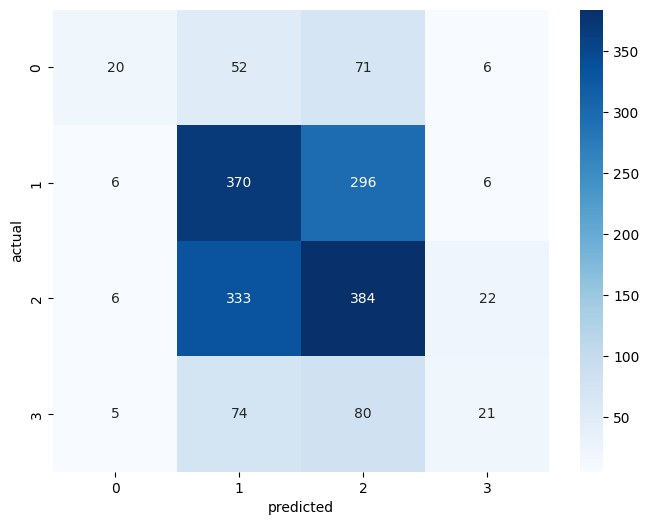

In [225]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_valid_pred_class)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=[0,1,2,3],yticklabels=[0,1,2,3])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()